## Descrição

- Treinar uma rede neural com 1 camada oculta e função de ativação tanh (tangente hiperbolica) usando algoritmo genetico e simulated annealing.
- tarefa: regressão de 1 variavel de entrada e 1 variavel de saida.
- funçao real: seno.
- Deve ser somado ruido Gaussiano aos pontos reais.
- conjunto de treino: pontos no intervalor -PI a PI.
- conjunto de teste: pontos no intervalor de 0 a 2 PI.
- Avaliar como o erro varia ao aumentar o numero de neuronios nos conjuntos de treino e teste.


## ENTREGAR
- tabela com erro para rede com 2,4,8,16,32,64,128 neuronios (Num neuronios | erro treino | erro teste)
- Grafico de evoluçao da fitness (erro no treino) para cada configuraçao
- Grafico da funçao final para cada configuraçao

In [ ]:
##FUNÇÕES 

def true_regression_fn(x): # troca pra coseno dps tangente
    return np.sin(x) + np.random.normal(loc=0.0, scale = 0.1)

def calculaRMSE(TREINO_ESCOPO,RESP_regression,rede):
    
    y_pred = []
    y = RESP_regression
    for input in TREINO_ESCOPO:
        data = processNN([input],rede)[0] # ja que é uma entrada e uma saida por isso do [0]
#         print(data)
        y_pred.append(data)
    
#     print("y_pred:",len(y_pred))
#     print("y:",len(y))

    error = np.subtract(y,y_pred)
    
#     print(error)
    return np.sqrt(np.mean(np.square(error)))
    

def processNN(entrada,rede):
    activations = []
    for l in rede:
        activations.append(l.forward(entrada))
        entrada = activations[-1]
    return entrada

def plot_fn(true_regression_fn, search_space, step=0.1):
    # plt.clf()
    x = np.arange(search_space[0], search_space[1], step)
    y = np.array(list(map(true_regression_fn, x)))
    plt.plot(x, y)

In [2]:
## SIMULATED ANNEALING
class SimulatedAnnealing():
    
    def __init__(self,search_space, DESVIO_PADRAO, temperature, alpha, num_vizinhos):
        self.search_space = search_space
        self.DESVIO_PADRAO = DESVIO_PADRAO
        self.temperature = temperature
        self.alpha = alpha
        self.num_vizinhos = num_vizinhos

    def gera_vizinhos(self,solucao):
        vizinhos = []
        
        for _ in range(self.num_vizinhos):

            #condiçao de mutaçao
            if random.uniform(0,1) <= 0.5:
                vizinho = solucao + np.random.normal(loc=0, scale=self.DESVIO_PADRAO)
                #adiciona gaussiana no dado

                # basicamente vai pegar outro vizinho enquanto estiver fora do espaço de busca
                while vizinho < self.search_space[0] or vizinho > self.search_space[1]:
                    if vizinho < self.search_space[0]:
                        ruido = abs(np.random.normal(loc=0, scale=self.DESVIO_PADRAO))
                    if vizinho > self.search_space[1]:
                        ruido = -abs(np.random.normal(loc=0, scale=self.DESVIO_PADRAO))
                    vizinho = solucao + ruido
            else:
                vizinho = random.uniform(self.search_space[0], self.search_space[1])
                #muda o dado para um valor aleatorio dentro do espaço de busca
            
            vizinhos.append(vizinho)

        return vizinhos
    
    def atTemperature(self):
        self.temperature *= self.alpha
        return self.temperature

In [3]:
## NN

class Camada():
    def __init__(self, input_units, output_units):
        # iniciando os pesos "aleatoriamente" (matriz)
        self.weights = np.random.uniform(low=-5, high = 5, size = (input_units,output_units))
        self.biases = np.random.uniform(low=-5, high = 5, size = output_units)
#         self.weights = np.zeros((input_units,output_units))
#         self.biases = np.zeros(output_units)
        #print("peso:",self.weights)
        #print("bias:",self.biases)
        
    def forward(self,inpt):
        # multiplicando o input com os pesos depois somando a bias + calculando o tanh
        dot = np.dot(inpt,self.weights)
        sum = dot + self.biases
        tanh = np.tanh(sum)
#         print("inpt:",inpt)
#         print("dot:",dot)
#         print("sum:",sum)
#         print("tanh:",tanh)
#         print("\n")
        
        return tanh #checar se o tamanho da matriz ta saindo correto


In [4]:
## MAIN SA

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from IPython import display
import tqdm
from copy import deepcopy

%matplotlib inline

N_POPULACAO = 50 #50
N_INTERACAO = 2000 #2000
# np.random.seed(0)
PI = np.pi
SEARCH_SPACE = [-5,5] #espaço de operaçao
TRAINING_SPACE = [-PI,PI] #espaço de treino

TESTE_ESCOPO = [] # escopo de entradas de teste da rede
aux = -2*PI
while aux <= 2*PI:
    TESTE_ESCOPO.append(aux)
    aux += 0.2

TREINO_ESCOPO = []
aux = TRAINING_SPACE[0]
for _ in range(32):
    TREINO_ESCOPO.append(aux)
    aux += 0.2
    
DESVIO_PADRAO = 0.3

RESP_regression = []
for x in TREINO_ESCOPO:
    RESP_regression.append(true_regression_fn(x))
    
tabelaRmse = []

In [ ]:
def main():
    
    # caso precise criar uma rede com varias entradas
#     entrada = [] # entrada varios valores
#     aux = -3
#     for _ in range(6):
#         entrada.append(aux)
#         aux += 1
    
    
    entrada = [0]

        
    RESP_regression = []
    for x in TREINO_ESCOPO:
        RESP_regression.append(true_regression_fn(x))
    
    
    tabelaNeural = [0]
    tabelaNeural = [2,4,8,16,32,64,128] # comenta essa linha para ativar o modo criar sua rede
    
    for tn in range(len(tabelaNeural)):
        rede = []
        RMSEs = []
        inLayer = len(entrada)
        if len(tabelaNeural) == 1:
            print("Quantas camadas você deseja que a rede tenha?")
            camadas = int(input()) # quantas camadas vc quer
            for i in range(camadas):
                print("Quantos neuronios na camada",i,"voce deseja?")
                outLayer = int(input()) # quantos neuronios vc quer
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
        else:
            camadas = 1    
            for i in range(camadas):
                outLayer = tabelaNeural[tn]
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
            print("EXECUTANDO TABELA NEURAL [ INTERACAO:",tn,"NEURONIOS:",tabelaNeural[tn],"]")
        rede.append(Camada(inLayer,len(entrada)))

        rmse = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)

        RMSEs.append(rmse)

        print("RMSE virgem:",rmse)        

        SA = SimulatedAnnealing(search_space = SEARCH_SPACE, # espaço de treino da rede
                                DESVIO_PADRAO = 0.3,
                                temperature = 100,
                                alpha = 0.995,
                                num_vizinhos = 1)

        # modificando um dado da rede para calcular o novo RMSE se ele melhora atualiza a rede, se nao vai para proxima interacao
        for p in tqdm.tqdm(range(N_POPULACAO*N_INTERACAO)):
            # extraindo ids da rede
            layerId = np.random.randint(len(rede))
            weighId = np.random.randint(len(rede[layerId].weights))
            neuroId = np.random.randint(len(rede[layerId].weights[weighId]))

#             print("camada[{}/{}], peso[{}/{}], neuronio[{}/{}] ".format(len(rede),layerId,len(rede[layerId].weights),weighId,len(rede[layerId].weights[weighId]),neuroId))
            
            # extraindo peso e bias
            peso = rede[layerId].weights[weighId][neuroId]
            bias = rede[layerId].biases[neuroId]

            # filtro para mudar Peso ou Bias
            if random.uniform(0,1) <= 0.5:
                isPeso = True
                data = peso
            else:
                isPeso = False
                data = bias
            
            vizinhos = SA.gera_vizinhos(data)
            for data_vizinha in vizinhos
                newRede = deepcopy(rede)

                if isPeso:
                    newRede[layerId].weights[weighId][neuroId] = data_vizinha
                else:
                    newRede[layerId].biases[neuroId] = data_vizinha

                newRMSE = calculaRMSE(TREINO_ESCOPO,RESP_regression,newRede)

                if newRMSE < rmse:
                    rmse = newRMSE # RMSE da nova  rede
                    rede = newRede # nova rede

                else:  # data_vizinha eh pior (delta >= 0)
                    delta = rmse - newRMSE
                    prob_aceitacao = np.exp(delta / SA.temperature)
                    if random.uniform(0, 1) < prob_aceitacao:
                        # data_vizinha eh aceito mesmo sendo pior.
                        rmse = newRMSE # RMSE da nova  rede
                        rede = newRede # nova rede
                
                SA.atTemperature()
                RMSEs.append(rmse)


        print("RMSE Final:", rmse)
        
        resultado_teste = []

        for te in TESTE_ESCOPO:
            resultado_teste.append(processNN([te],rede)[0])
            
        resultado_treino=[]
        for te in TREINO_ESCOPO:
            resultado_treino.append(processNN([te],rede)[0])

    
        # adiciona o Rmse final a tabela 
        tabelaRmse.append([tabelaNeural[tn], rmse])
        
        
        # plota o conjunto de treinamento + conjunto de teste
        figure= plt.subplots(figsize=(10, 8))
        plt.title("RMSE", fontsize=20)
        plt.xlabel("interacoes")
        plt.ylabel("Fo")
        plt.subplot(2, 1, 1)
        plt.cla()
        plot_fn(true_regression_fn, SEARCH_SPACE)
        plt.plot(TREINO_ESCOPO, RESP_regression,'*g', markersize=7)
        plt.plot(TESTE_ESCOPO, resultado_teste,'*r', markersize=7)
        plt.plot(TREINO_ESCOPO, resultado_treino,'*b', markersize=7)
        plt.title("Result (green) and predict (red)")

        plt.subplot(2, 1, 2)
        # plta o avanço do rmse 
        plt.title("RMSEs")
        plt.plot(RMSEs)
        plt.show()

        
    #printa a tabela
    print("TABELA DE RMSEs")
    print(pd.DataFrame(tabelaRmse, columns=["qntNeuronios", "rmse"]))


    
    
    
if __name__ == "__main__":
    main()

### ALGORITMO GENETICO

Passos:
Cria-se uma populaçao de 50 individuo (vetor de individuos criado)
- cada individuo tem seu gene, seu gene é a rede neural vetorizada
- calcula-se sua aptidão, seria o resultado da rede calculando o RMSE

Inicia-se um loop para cada individuo da populaçao: (isso representa uma geraçao)
- Elitismo, escolhe o melhor individuo (o que possui a melhor aptidao), reservo-o para o final
- Torneio, duelo entre 2 pessoas aleatorios e o mais forte vence é separado para cruzar com outro que vencer o duelo tambem.
- - CrossOver, Misturo os genes de 2 individuos vencedores do duelo, gerando uma nova populaçao que serao os filhos
- Mutaçao, (10%), individuo selecionado seu genes sao randomizados no intervalo (50%), ou adiciona-se um ruido no gene (gene é a rede neural)
- - Na mutação, cada filho tem 10% de chance de mutar. A mutação é igual no SA. Um peso ou bias aleatório do indivíduo é transformado (nota que não são todos os números, é 1 só).
- calculo aptidao, calculo o RMSE de todos os individuos (rodo a rede que eles carregam e vejo o resultado no RMSE)
- add Elite, em toda populaçao procuro o PIOR individuo e substituo-o pelo elite do inicio do loop

Repete-se o loop de cima 2000x que é o total de geraçoes percorridas

100%|██████████| 2000/2000 [00:52<00:00, 37.91it/s]


rmse Elite: 1.637038679391711


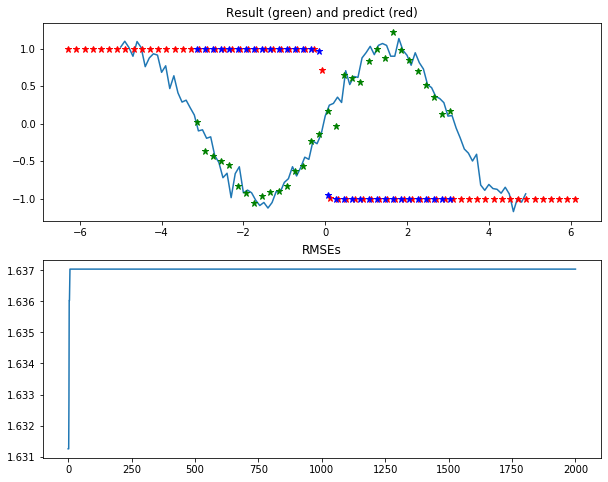

100%|██████████| 2000/2000 [01:04<00:00, 30.79it/s]


rmse Elite: 1.6367968386353464


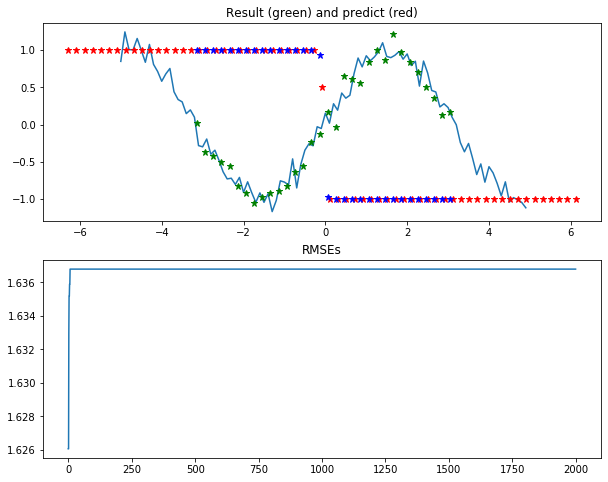

 16%|█▌        | 320/2000 [00:10<00:52, 32.31it/s]

KeyboardInterrupt: 

 16%|█▌        | 320/2000 [00:30<00:52, 32.31it/s]

In [5]:
class individuo():
    def __init__(self,rede,aptidao):
        self.gene = rede
        self.aptidao = aptidao

        
def elitism(populacao):
    bestSheep = populacao[0]
    for ind in populacao:
        if ind.aptidao > bestSheep.aptidao:
            bestSheep = ind
    return bestSheep
        
    
def selection(populacao):

    strongPopulation = []
    for ind in populacao:
        oponente = populacao[np.random.randint(0,len(populacao))]
        
        if oponente.aptidao >= ind.aptidao:
            strongPopulation.append(oponente)
        else:
            strongPopulation.append(ind)
    
    # populaçao dos mais fortes (deve repetir individuo)
    filhosFortes = []
    for indId in range(len(strongPopulation)//2):
        ind1 = strongPopulation[np.random.randint(0,len(strongPopulation))]
        ind2 = strongPopulation[np.random.randint(0,len(strongPopulation))]
        son1, son2 = crossOver(ind1,ind2)
        filhosFortes.append(son1)
        filhosFortes.append(son2)
    
    return filhosFortes

        
def crossOver(individuo1,individuo2):
    c1, c2 = deepcopy(individuo1), deepcopy(individuo2)
    A = random.uniform(0,1)
    for i in range(len(individuo1.gene)): # tamanho de camadas da rede
        peso1 = individuo1.gene[i].weights # matriz de peso
        peso2 = individuo2.gene[i].weights
        biases1 = individuo1.gene[i].biases # vetor de peso
        biases2 = individuo2.gene[i].biases

        c1.gene[i].weights = A*peso1+(1-A)*peso2 # cruzando matriz peso
        c2.gene[i].weights = A*peso2+(1-A)*peso1
        c1.gene[i].biases = A*biases1+(1-A)*biases2 # cruzando vetor de biases
        c2.gene[i].biases = A*biases2+(1-A)*biases1

    return c1,c2

def mutation(populacao):
    for ind in populacao:
        chance = np.random.randint(0, 100)
        if chance <= 10:
            isPeso = False
            rede = deepcopy(ind.gene)
            # pega um peso/bias aleatorio
            layerId = np.random.randint(len(rede))
            weighId = np.random.randint(len(rede[layerId].weights))
            neuroId = np.random.randint(len(rede[layerId].weights[weighId]))

            # extraindo peso e bias
            peso = rede[layerId].weights[weighId][neuroId]
            bias = rede[layerId].biases[neuroId]

            # filtro para mudar Peso ou Bias
            if random.uniform(0,1) <= 0.5:
                isPeso = True
                data = peso
            else:
                isPeso = False
                data = bias

            if random.uniform(0,1) <= 0.5:
                newdata = data + np.random.normal(loc=0, scale=DESVIO_PADRAO)
                #adiciona gaussiana no dado
                # basicamente vai pegar outro vizinho enquanto estiver fora do espaço de busca
                while newdata < SEARCH_SPACE[0] or newdata > SEARCH_SPACE[1]:
                    newdata = data + np.random.normal(loc=0, scale=DESVIO_PADRAO)
            else:
                newdata = random.uniform(SEARCH_SPACE[0], SEARCH_SPACE[1])
                #muda o dado para um valor aleatorio dentro do espaço de busca


            if isPeso:
                rede[layerId].weights[weighId][neuroId] = newdata
            else:
                rede[layerId].biases[neuroId] = newdata

            ind.genes = rede

    return populacao

def calc_aptidao(populacao,TREINO_ESCOPO,RESP_regression):
    for ind in populacao:
        ind.aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,ind.gene)
    return populacao

def addElite(populacao,elite):
    blackSheep = populacao[0]
    posBS = 0
    for pos,ind in enumerate(populacao):
        if ind.aptidao < blackSheep.aptidao:
            blackSheep = ind
            posBS = pos
    populacao[posBS] = elite
    return populacao


def main():
    
    entrada = [0]
    tabelaNeural = [0]
    tabelaNeural = [2,4,8,16,32,64,128]
    
    
    if len(tabelaNeural) == 1:
        print("Quantas camadas você deseja que a rede tenha?")
        camadas = int(input()) # quantas camadas vc quer
        for i in range(camadas):
            print("Quantos neuronios na camada",i,"voce deseja?")
            outLayer = int(input()) # quantos neuronios vc quer
            tabelaNeural.append(outLayer)
    else:
        camadas = 1    

    for tn in range(len(tabelaNeural)):
        populacao = []
        RMSEs = []
        
        for i in tqdm.tqdm(range(N_POPULACAO)):
            rede = []
            inLayer = len(entrada)
            for i in range(camadas):
                outLayer = tabelaNeural[tn]
                rede.append(Camada(inLayer,outLayer))
                inLayer = outLayer
            rede.append(Camada(inLayer,len(entrada)))
            #fez a rede
            aptidao = calculaRMSE(TREINO_ESCOPO,RESP_regression,rede)
            populacao.append(individuo(rede,aptidao))
        
        elite = elitism(populacao)
        RMSEs.append(elite.aptidao)
        for _ in tqdm.tqdm(range(N_INTERACAO)):
            populacao = selection(populacao)
            populacao = mutation(populacao)
            populacao = calc_aptidao(populacao,TREINO_ESCOPO,RESP_regression)
            populacao = addElite(populacao,elite)
            elite = elitism(populacao)
            
            RMSEs.append(elite.aptidao)
            
        print("rmse Elite:",elite.aptidao)
        
        resultado_teste = []

        for te in TESTE_ESCOPO:
            resultado_teste.append(processNN([te],elite.gene)[0])
            
        resultado_treino=[]
        for te in TREINO_ESCOPO:
            resultado_treino.append(processNN([te],elite.gene)[0])

    
        # adiciona o Rmse final a tabela 
        tabelaRmse.append([tabelaNeural[tn], elite.aptidao])
        
        
        # plota o conjunto de treinamento + conjunto de teste
        plt.subplots(figsize=(10, 8))
        plt.title("RMSE", fontsize=20)
        plt.xlabel("interacoes")
        plt.ylabel("Fo")
        plt.subplot(2, 1, 1)
        plt.cla()
        plot_fn(true_regression_fn, SEARCH_SPACE)
        plt.plot(TREINO_ESCOPO, RESP_regression,'*g', markersize=7)
        plt.plot(TESTE_ESCOPO, resultado_teste,'*r', markersize=7)
        plt.plot(TREINO_ESCOPO, resultado_treino,'*b', markersize=7)
        plt.title("Result (green) and predict (red)")

        plt.subplot(2, 1, 2)
        # plta o avanço do rmse 
        plt.title("RMSEs")
        plt.plot(RMSEs)
        plt.show()

        
    #printa a tabela
    print("TABELA DE RMSEs")
    print(pd.DataFrame(tabelaRmse, columns=["qntNeuronios", "rmse"]))
    

if __name__ == "__main__":
    main()